## Going through all single runs

In [1]:
#Going through metrics
import numbers
import glob
import os
import csv

if True:
    combined_data_ = {}
    target_kernels = []
    
metric_targets = []
all_sig_metrics = []
bench_targets = [ "gaussian" ,"gemm", "stream" ]
for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/mixed_results/*.csv"):
#for filen_ in glob.glob("/home/yzamora/power/nvidia_gpus/all_apps/gaussian_results/*.csv"):
    filen = os.path.basename(filen_)
    #print (filen)
    filen_split = filen.split('.')[0].split('_')
    bench_name = filen_split[0]
    size = filen_split[1]
    #metric_name = filen_split[1]
    #print(filen_split)
    #size_str = filen_split[1].split('N')[1]
    
    #if not (metric_name in metric_targets): continue
    #if not (bench_name in bench_targets): continue
    
    key_root = bench_name
    #print(key_root)
    levels = ["Idle", "Low","High", "Max"]
    bw_units = ["GB", "MB", "KB" ,"0B"]
    # Now open the file and look for the data
    with open(filen_ ,'r') as file_handle:
        #print (file_handle)
        data_found = False
        ncols = 1
        fdata = csv.reader(file_handle)
        index_lookup = {}
        #print(filen_)
        for line_split in fdata:
            #print (line_split)
            lsplt = (len(line_split) > 0)
      
            if data_found:
                #print("data found")
                if lsplt and len(line_split) == ncols:
                    #percent - strip off end
                    # Get metric name here
                    #mname_index = index_lookup['Metric Name']
                    #metric_name = line_split[ mname_index ]
                    #if not (metric_name in metric_targets): continue
                    
                    # Read in desired value for the current metric
                    target_index = index_lookup['Avg']; value = 0
                    metric_name = line_split[index_lookup['Metric Name']]
                    #print (line_split[target_index].isdecimal())
                    if line_split[target_index].isdecimal():
                        if line_split[target_index]!= '0':
                            #print(line_split[target_index])
                            all_sig_metrics.append(metric_name)
                            value = int(line_split[ target_index ])
                        
                        # Labeled with percentage
                    elif "%" == line_split[target_index][-1]:
                        #print ("percentage loop")
                        all_sig_metrics.append(metric_name)
                        value = float(line_split[ target_index ][0:7]) / 100.0
                        
                    # Labeled with bandwidth units
                    elif line_split[ target_index ][-4:-2] in bw_units:
                        # Just take the first 
                        units = line_split[ target_index ][-4:-2]
                        all_sig_metrics.append(metric_name)
                        mfact = 1.0
                        if   units == "KB": mfact = 1024
                        elif units == "MB": mfact = 1024*1024
                        elif units == "GB": mfact = 1024*1024*1024
                        elif units == "0B":  mfact = 1
                        value = float(line_split[ target_index ][0:7]) * mfact
                    
                    # idle, low, max
                    elif line_split[ target_index ][-1] == ")":
                        #print ("low")
                        all_sig_metrics.append(metric_name)
                        value = int(line_split[ target_index].split('(')[1].split(")")[0])
                        
                    # otherwise, float
                    #elif not(float(line_split[ target_index ]).is_integer()):
                    else:
                        #print(line_split[ target_index ].split('(')[0])
                        #print("in float")
                        #print(line_split[ target_index ].split('(')[0])
                        value = float(line_split[ target_index ])
                    
                    
                    
                     # Parse name of kernel
                    kernel_name = line_split[ index_lookup['Kernel'] ].split('(')[0]
                    
                    # Define kernel-specific key
                    key = key_root + size + "_" + kernel_name 
                    
                    # Initialize dict for this key, if it is new
                    if not (key in combined_data_): 
                        combined_data_ [ key ] = {}
                    if not (kernel_name in target_kernels):
                        target_kernels.append(kernel_name)
                        #combined_data_ [ key ][ 'size' ] = int( size_str )
                        
                    # Store value for the metric being read right now
                    combined_data_ [key][ metric_name ] = value
                    combined_data_[key]["kernelname"] = kernel_name
                    
                else: data_found = False


            elif lsplt and line_split[0] == 'Device' and line_split[1] == 'Kernel':
                # Set flag that we are at the data:
                data_found = True
                # Set number of columns in table:
                ncols = len(line_split)
                # Generate an index lookup table:
                idx = 0
                for term in line_split:
                    index_lookup[term] = idx
                    idx += 1
                #print(index_lookup)



In [2]:
#print(combined_data_['']['kernalname'])
#print(combined_data_)
print(target_kernels)

['sgemm_128x128x8_NN_vec', 'maxwell_sgemm_128x64_nn', 'sgemm_32x32x32_NN_vec', 'Fan2', 'Fan1', 'set_array', 'STREAM_Triad', 'STREAM_Scale', 'STREAM_Copy', 'STREAM_Add', 'invert_mapping', 'kmeansPoint', 'mergeSortFirst', 'mergepack', 'histogram1024Kernel', 'bucketsort', 'mergeSortPass', 'bucketprefixoffset', 'bucketcount']


In [3]:
import os
import sys
import pandas as pd
%matplotlib inline
df = pd.DataFrame.from_dict(combined_data_,orient='index')
print(df.shape)
#print(scale(df))
#print((df['kernelname'].tolist()))

(2143, 119)


In [4]:
from matplotlib import colors as mcolors

all_colors = []
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
for name, color in colors.items():
    if len(name) == 1:
        all_colors.append(name + "o")
    else:
        all_colors.append(name)
#print(all_colors)

/home/yzamora/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


n_digits: 19, 	 n_samples 2143, 	 n_features 118
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.41s	23938	0.707	0.757	0.731	0.441	0.699	0.499
random   	0.20s	29980	0.732	0.712	0.722	0.410	0.704	0.467
PCA-based	0.03s	29632	0.660	0.737	0.696	0.364	0.650	0.426
__________________________________________________________________________________


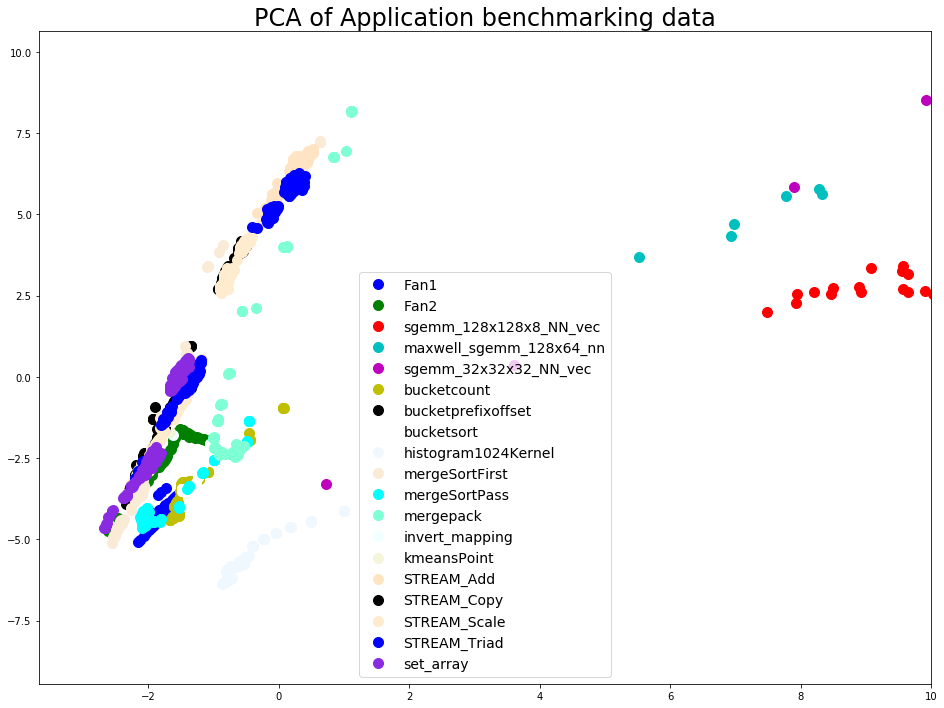

In [25]:
# print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
%matplotlib inline

#np.random.seed(42)
labels = df['kernelname'].tolist()
#print(n_samples, n_features)
df2 = df.drop(columns=['kernelname'])

#digits = load_digits()
#data = scale(digits.data)
data = scale(df2.values)

n_samples, n_features = data.shape
n_digits = len(target_kernels)

"""
np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

print("digits", digits)
print("data", data)
print("n_samples", n_samples)
print("labels",labels)
"""

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
#plt.figure(1)
plt.figure(figsize=(16,12))
plt.clf()
"""
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)


"""
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.',markersize=2)

x =[]
y =[]
plot_dict = {}
for i in range(len(labels)):    
    if labels[i] in plot_dict:
        plot_dict[ labels[i] ][0].append( reduced_data[i, 0] )
        plot_dict[ labels[i] ][1].append( reduced_data[i, 1] )
    else:
        plot_dict[ labels[i] ] = [ ]
        plot_dict[ labels[i] ].append( [reduced_data[i, 0]] )
        plot_dict[ labels[i] ].append( [reduced_data[i, 1]] )
        #'bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko', 'wo',
clr = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 
       'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate'
       , 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 
       'darkgreen', 'darkgrey', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 
       'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 
       'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 
       'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 
       'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue',
       'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue',
       'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive', 'olivedrab', 'orange', 'orangered', 
       'orchid']
#clr = [ 'bo', 'ko', 'go', 'co', 'yo', 'ro', 'bx', 'kx', 'gx', 'cx', 'yx', 'rx']
cind=0
for k,v in plot_dict.items():
    plt.plot(v[0], v[1], color = clr[cind], label=k,  markersize=10, marker ='o', linestyle = 'None' )
    cind+=1

"""
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)"""
#plt.title('K-means clustering Application benchmarking data (PCA-reduced data)\n'
          #'Centroids are marked with white cross')
plt.title("PCA of Application benchmarking data",fontsize=24 )
plt.xlim(x_min, 10)
plt.ylim(y_min, y_max)
#plt.xticks(())
#plt.yticks(())
plt.legend(loc='best',prop={'size':14})
plt.savefig("PCA")
plt.show()

In [12]:
# Projecting the 118 dimensional space to a 2-d space where the data points belong to the targets.
